Files already downloaded and verified
Files already downloaded and verified


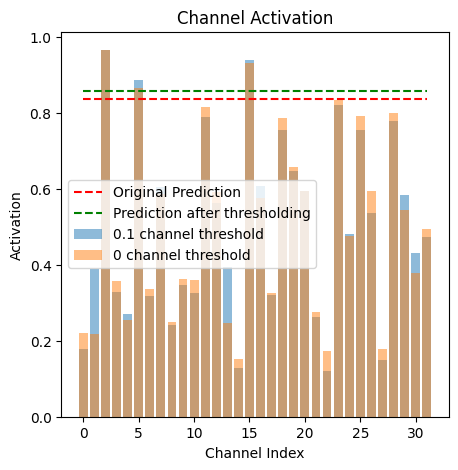

In [2]:
# load the image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sys
from Dataloaders import dataloader_cifar10
from Models import gatedmodel, mobilenetv2
from Utils import utils
import torch
import matplotlib.pyplot as plt

train, test, val = dataloader_cifar10.Dataloader_cifar10_val()
client, server = mobilenetv2.mobilenetv2_splitter(weight_root='./Weights/cifar-10/', num_classes=10)

# get the client out 
client = client.cuda()
client.eval()
# freeze the grad 
for param in client.parameters():
    param.requires_grad = False

server = server.cuda()
server.eval()
# freeze the grad
for param in server.parameters():
    param.requires_grad = False

rate = [x/31 for x in range(32)]
accuracy = []

for ind, (img, label) in enumerate(val):
    img = img.cuda()
    label = label.cuda()
    break
    
out = client(img).detach()

# rank the output with zeros
c_rank = utils.ranker_zeros(out, 0.1, 0.5)
c_rank_non = utils.ranker_zeros(out, 0, 0.5)

c_act = np.zeros((128,32))
c_act_non = np.zeros((128,32))
for i in range(128):
    for j in range(32):
        c_act[i,c_rank[i,j]] = (31-j)/31
        c_act_non[i,c_rank_non[i,j]] = (31-j)/31
                                     

# plot the channel activation
plt.figure(figsize=(5,5))
# hist plot
c_act_mean = np.mean(c_act, axis=0)
c_act_non_mean = np.mean(c_act_non, axis=0)

plt.bar(range(32), c_act_mean, alpha=0.5, label='0.1 channel threshold')
plt.bar(range(32), c_act_non_mean, alpha=0.5, label='0 channel threshold')
plt.legend()
plt.xlabel('Channel Index')
plt.ylabel('Activation')
plt.title('Channel Activation')


# change the small value to zeros
out_cut = out.clone()
out_cut[torch.abs(out) < 0.1] = 0

pred = server(out).detach()
pred = torch.argmax(pred, dim=1)
pred_th = server(out_cut).detach()
pred_th = torch.argmax(pred_th, dim=1)

pred_acc = torch.sum(pred == label).item()/128
pred_th_acc = torch.sum(pred_th == label).item()/128

pred_x = [x for x in range(32)]
# plot a straigh line
plt.plot(pred_x, [pred_acc]*32, 'r--', label='Original Prediction')
plt.plot(pred_x, [pred_th_acc]*32, 'g--', label='Prediction after thresholding')
plt.legend()

# plot Q1: could we change some small value to zeros?
plt.show()

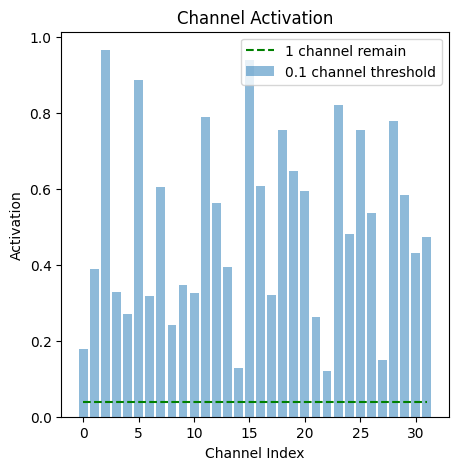

In [3]:
# second plot, use only one channel to see the effect
c_rank = utils.ranker_zeros(out_cut, 0.1, 0.5)
n_emb = torch.zeros_like(out_cut)
for i in range(128):
    n_emb[i,c_rank[i,0]] = out_cut[i,c_rank[i,0]]
   
pred_one = server(n_emb).detach()
pred_one = torch.argmax(pred_one, dim=1)

pred_one_acc = torch.sum(pred_one == label).item()/128

plt.figure(figsize=(5,5))
plt.bar(range(32), c_act_mean, alpha=0.5, label='0.1 channel threshold')
plt.xlabel('Channel Index')
plt.ylabel('Activation')
plt.title('Channel Activation')
plt.plot(pred_x, [pred_one_acc]*32, 'g--', label='1 channel remain')
plt.legend()
# plot Q2: using only one channel to see the effect?
plt.show()



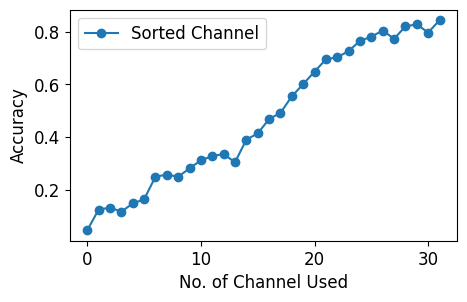

In [11]:
# second plot, use only one channel to see the effect
from Utils import utils
c_rank = utils.ranker_zeros(out_cut, 0.1, 0.5)
for i in range(128):
    c_rank[i] = torch.flip(c_rank[i], dims=[0])
n_embs = [] #128,n,32,32 * 32
for j in range(32):
    n_emb = torch.zeros_like(out_cut)
    for i in range(128):
        for k in range (j):
            n_emb[i,c_rank[i,k]] = out_cut[i,c_rank[i,k]]
    n_embs.append(n_emb)
pred_orders = []
for n_emb in n_embs:
    pred_order = server(n_emb).detach()
    pred_order = torch.argmax(pred_order, dim=1)
    pred_orders.append(pred_order)
pred_order_accs = []
for pred_order in pred_orders:
    pred_order_acc = torch.sum(pred_order == label).item()/128
    pred_order_accs.append(pred_order_acc)

plt.figure(figsize=(5,3))
# plt.plot(pred_x, pred_order_accs, 'g--', label='Remove value < 0.1')
plt.xlabel('No. of Channel Used')
plt.ylabel('Accuracy')
# plt.legend()


c_rank = utils.ranker_zeros(out, 0.1, 0.5)
for i in range(128):
    c_rank[i] = torch.flip(c_rank[i], dims=[0])
# reverse the c_rank
n_embs = [] #128,n,32,32 * 32
for j in range(32):
    n_emb = torch.zeros_like(out)
    for i in range(128):
        for k in range (j):
            n_emb[i,c_rank[i,k]] = out[i,c_rank[i,k]]
    n_embs.append(n_emb)
pred_orders = []
for n_emb in n_embs:
    pred_order = server(n_emb).detach()
    pred_order = torch.argmax(pred_order, dim=1)
    pred_orders.append(pred_order)
pred_order_accs = []
for pred_order in pred_orders:
    pred_order_acc = torch.sum(pred_order == label).item()/128
    pred_order_accs.append(pred_order_acc)

plt.plot(pred_x, pred_order_accs, 'o-', label='Sorted Channel')
# scatter plot
# plt.scatter(pred_x, pred_order_accs, c='orange', marker='x')

plt.xlabel('No. of Channel Used', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.locator_params(axis='x', nbins=6)
plt.locator_params(axis='y', nbins=6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend(fontsize = 12)

plt.savefig('./Plots/Channel_Accuracy.pdf')
# add the zerocount of each channel, examples
plt.show()
# plot Q3: using the number of number

100%|██████████| 11/11 [00:01<00:00, 10.62it/s]


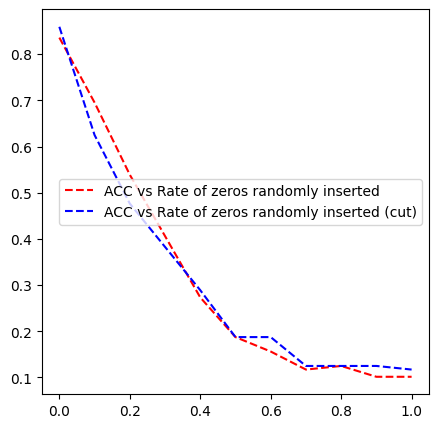

In [5]:
# add the zerocount of each channel, examples
from tqdm import tqdm
# get the number of zeros and positions
out_cpu = out.cpu().numpy()
nz_c = np.sum(out_cpu != 0, axis=(1,2,3))

nz_pos = []
for i in tqdm(range(128)):
    zero_pos = []
    for j in range(32):
        for k in range(16):
            for l in range(16):
                if out_cpu[i,j,k,l] != 0:
                    zero_pos.append((j,k,l))
    nz_pos.append(zero_pos)
# following the upper block
more_zeros = [x/10 for x in range (11)]
# reverse the order
accuracy = []
for n_z in tqdm(more_zeros):
    emb = np.copy(out_cpu)
    for ind, zp in enumerate(nz_pos): # 128
        e_temp = emb[ind]
        n_zero = n_z*nz_c[ind] # no of numbers needed to insert to the e_temp
        # sample the zero positions
        r_zero = np.random.choice(nz_c[ind], int(n_zero))
        for r_z in r_zero:
            e_temp[zp[r_z]] = 0
        emb[ind] = e_temp
    emb = torch.tensor(emb).cuda()
    pred = server(emb).detach()
    pred = torch.argmax(pred, axis=1)
    pred_acc = torch.sum(pred == label).item()/128
    accuracy.append(pred_acc)

plt.figure(figsize=(5,5))
plt.plot(more_zeros, accuracy, 'r--', label='ACC vs Rate of zeros randomly inserted')

out_cut_cpu = out_cut.cpu().numpy()
nz_c = np.sum(out_cut_cpu != 0, axis=(1,2,3))

nz_pos = []
for i in tqdm(range(128)):
    zero_pos = []
    for j in range(32):
        for k in range(16):
            for l in range(16):
                if out_cut_cpu[i,j,k,l] != 0:
                    zero_pos.append((j,k,l))
    nz_pos.append(zero_pos)
# following the upper block
more_zeros = [x/10 for x in range (11)]
# reverse the order
accuracy = []
for n_z in tqdm(more_zeros):
    emb = np.copy(out_cut_cpu)
    for ind, zp in enumerate(nz_pos): # 128
        e_temp = emb[ind]
        n_zero = n_z*nz_c[ind] # no of numbers needed to insert to the e_temp
        # sample the zero positions
        r_zero = np.random.choice(nz_c[ind], int(n_zero))
        for r_z in r_zero:
            e_temp[zp[r_z]] = 0
        emb[ind] = e_temp
    emb = torch.tensor(emb).cuda()
    pred = server(emb).detach()
    pred = torch.argmax(pred, axis=1)
    pred_acc = torch.sum(pred == label).item()/128
    accuracy.append(pred_acc)
plt.plot(more_zeros, accuracy, 'b--', label='ACC vs Rate of zeros randomly inserted (cut)')
plt.legend()
plt.show()


In [6]:
# how many zeros are added between original and cut
nz_c = np.sum(out_cpu == 0, axis=(1,2,3))

nz_c_cut = np.sum(out_cut_cpu == 0, axis=(1,2,3))

print('The number of zeros in the original output is:', np.mean(nz_c))
print('The number of zeros in the cut output is:', np.mean(nz_c_cut))

The number of zeros in the original output is: 1923.9453125
The number of zeros in the cut output is: 2354.9375


  5%|▌         | 7/128 [00:00<00:01, 60.89it/s]


KeyboardInterrupt: 

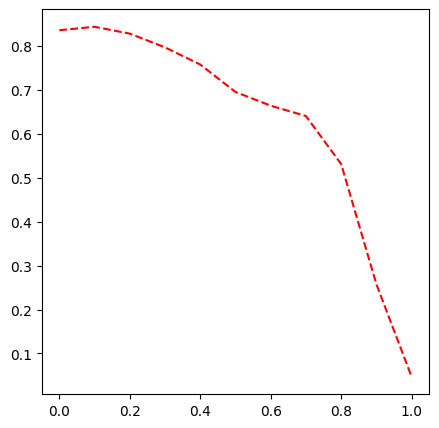

In [7]:
# what if we add 0 ordered by the value?
from tqdm import tqdm
# get the number of zeros and positions
out_cpu = out.cpu().numpy()
# reverse the order
nz_c = np.sum(out_cpu != 0, axis=(1,2,3))

nz_pos = []
for i in tqdm(range(128)):
    zero_pos = []
    for j in range(32):
        for k in range(16):
            for l in range(16):
                if out_cpu[i,j,k,l] != 0:
                    zero_pos.append((out_cpu[i,j,k,l], j,k,l))
    zero_pos = sorted(zero_pos, key=lambda x: x[0])
    nz_pos.append(zero_pos)
# following the upper block
more_zeros = [x/10 for x in range (11)]
# reverse the order
accuracy = []
for n_z in tqdm(more_zeros):
    emb = np.copy(out_cpu)
    for ind, zp in enumerate(nz_pos): # 128
        e_temp = emb[ind]
        n_zero = n_z*nz_c[ind] # no of numbers needed to insert to the e_temp
        # sample the zero positions
        # r_zero = np.random.choice(nz_c[ind], int(n_zero))
        for r_z in zp[:int(n_zero)]:
            e_temp[r_z[1:]] = 0
        emb[ind] = e_temp
    emb = torch.tensor(emb).cuda()
    pred = server(emb).detach()
    pred = torch.argmax(pred, dim=1)
    pred_acc = torch.sum(pred == label).item()/128
    accuracy.append(pred_acc)

plt.figure(figsize=(5,5))
plt.plot(more_zeros, accuracy, 'r--', label='ACC vs Rate of zeros o_b value inserted')

out_cut_cpu = out_cut.cpu().numpy()
nz_c = np.sum(out_cut_cpu != 0, axis=(1,2,3))

nz_pos = []
for i in tqdm(range(128)):
    zero_pos = []
    for j in range(32):
        for k in range(16):
            for l in range(16):
                if out_cut_cpu[i,j,k,l] != 0:
                    zero_pos.append((out_cut_cpu[i,j,k,l], j,k,l))
    zero_pos = sorted(zero_pos, key=lambda x: x[0])
    nz_pos.append(zero_pos)
# following the upper block
more_zeros = [x/10 for x in range (11)]
# reverse the order
accuracy = []
for n_z in tqdm(more_zeros):
    emb = np.copy(out_cut_cpu)
    for ind, zp in enumerate(nz_pos): # 128
        e_temp = emb[ind]
        n_zero = n_z*nz_c[ind] # no of numbers needed to insert to the e_temp
        # sample the zero positions
        # r_zero = np.random.choice(nz_c[ind], int(n_zero))
        for r_z in zp[:int(n_zero)]:
            e_temp[r_z[1:]] = 0
        emb[ind] = e_temp
    emb = torch.tensor(emb).cuda()
    pred = server(emb).detach()
    pred = torch.argmax(pred, dim=1)
    pred_acc = torch.sum(pred == label).item()/128
    accuracy.append(pred_acc)

plt.plot(more_zeros, accuracy, 'b--', label='ACC vs Rate of zeros o_b value inserted (cut)')
plt.legend()
plt.title('Ordered by value every channel, Acend, small to large')
plt.show()


normalized - original: 0.7812
normalized - cut: 0.7812


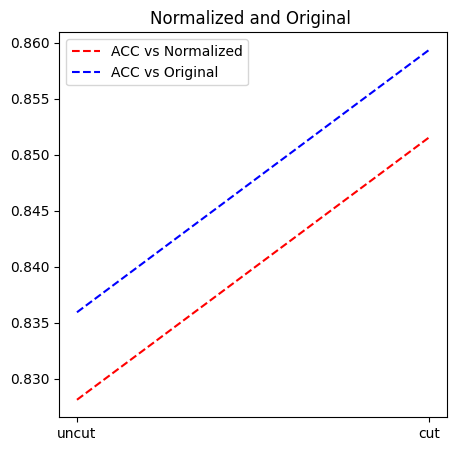

[0.8359375, 0.859375]


In [163]:
# can we change the value after normalization from 0-max to 0-255
from tqdm import tqdm
# get the number of zeros and positions
norm_acc = []
orig_acc = []

out_cpu = out.cpu().numpy()

out_cpu_max = np.max(out_cpu, axis=(1,2,3))
out_cpu_min = np.min(out_cpu, axis=(1,2,3))

out_cpu = (out_cpu - out_cpu_min[:,None,None,None])/(out_cpu_max[:,None,None,None] - out_cpu_min[:,None,None,None])
out_cpu = out_cpu*255
out_cpu = out_cpu.astype(np.uint8)

# encode and store it
import base64
enc_out_cpu = base64.b64encode(out_cpu[0,:10,:,:])
with open('enc_out_cpu.txt', 'wb') as f:
    f.write(enc_out_cpu)

emb = out_cpu.astype(np.float32)
emb = emb/255*(out_cpu_max[:,None,None,None] - out_cpu_min[:,None,None,None]) + out_cpu_min[:,None,None,None]
emb = torch.tensor(emb).cuda()
pred = server(emb).detach()
pred = torch.argmax(pred, dim=1)
pred_acc = torch.sum(pred == label).item()/128
norm_acc.append(pred_acc)

out_cut_cpu = out_cut.cpu().numpy()
out_cut_cpu_max = np.max(out_cut_cpu, axis=(1,2,3))
out_cut_cpu_min = np.min(out_cut_cpu, axis=(1,2,3))

out_cut_cpu = (out_cut_cpu - out_cut_cpu_min[:,None,None,None])/(out_cut_cpu_max[:,None,None,None] - out_cut_cpu_min[:,None,None,None])
out_cut_cpu = out_cut_cpu*255
out_cut_cpu = out_cut_cpu.astype(np.uint8)

emb = out_cut_cpu.astype(np.float32)
emb = emb/255*(out_cut_cpu_max[:,None,None,None] - out_cut_cpu_min[:,None,None,None]) + out_cut_cpu_min[:,None,None,None]
emb = torch.tensor(emb).cuda()

pred = server(emb).detach()
pred = torch.argmax(pred, dim=1)
pred_acc = torch.sum(pred == label).item()/128
norm_acc.append(pred_acc)

# original

pred = server(out).detach()
pred = torch.argmax(pred, dim=1)
pred_acc = torch.sum(pred == label).item()/128
orig_acc.append(pred_acc)

pred = server(out_cut).detach()
pred = torch.argmax(pred, dim=1)
pred_acc = torch.sum(pred == label).item()/128
orig_acc.append(pred_acc)

plt.figure(figsize=(5,5))
plt.plot([0,1], norm_acc, 'r--', label='ACC vs Normalized')
plt.plot([0,1], orig_acc, 'b--', label='ACC vs Original')
plt.xticks([0,1], ['uncut', 'cut'])
plt.legend()
plt.title('Normalized and Original ')
print('normalized - original: %.4f'%(100*(orig_acc[0] - norm_acc[0])))
print('normalized - cut: %.4f'% (100*(orig_acc[1] - norm_acc[1])))

plt.show()

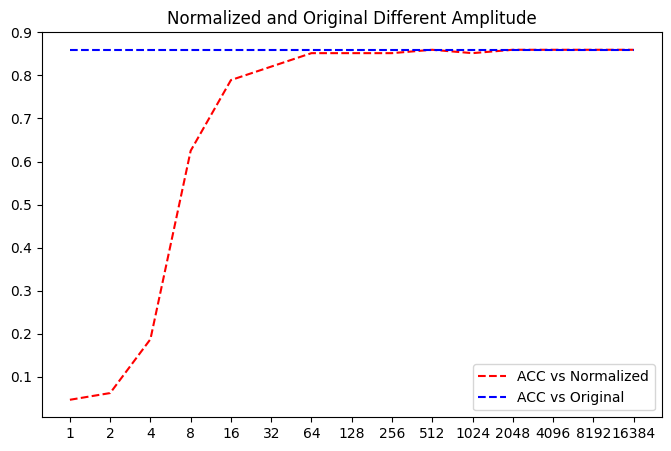

In [178]:
# can we change the value after normalization from 0-max to 0-16
from tqdm import tqdm
# get the number of zeros and positions
norm_acc = []
orig_acc = []

amp_list = [x for x in range(15)]
for i in range (len(amp_list)):
    amp = 2**i

    # out_cpu = out.cpu().numpy()

    # out_cpu_max = np.max(out_cpu, axis=(1,2,3))
    # out_cpu_min = np.min(out_cpu, axis=(1,2,3))

    # out_cpu = (out_cpu - out_cpu_min[:,None,None,None])/(out_cpu_max[:,None,None,None] - out_cpu_min[:,None,None,None])
    # out_cpu = out_cpu*amp
    # out_cpu = out_cpu.astype(np.uint8)

    # # encode and store it
    # import base64
    # enc_out_cpu = base64.b64encode(out_cpu[0,:10,:,:])
    # with open('enc_out_cpu.txt', 'wb') as f:
    #     f.write(enc_out_cpu)

    # emb = out_cpu.astype(np.float32)
    # emb = emb/amp*(out_cpu_max[:,None,None,None] - out_cpu_min[:,None,None,None]) + out_cpu_min[:,None,None,None]
    # emb = torch.tensor(emb).cuda()
    # pred = server(emb).detach()
    # pred = torch.argmax(pred, dim=1)
    # pred_acc = torch.sum(pred == label).item()/128
    # norm_acc.append(pred_acc)

    out_cut_cpu = out_cut.cpu().numpy()
    out_cut_cpu_max = np.max(out_cut_cpu, axis=(1,2,3))
    out_cut_cpu_min = np.min(out_cut_cpu, axis=(1,2,3))

    out_cut_cpu = (out_cut_cpu - out_cut_cpu_min[:,None,None,None])/(out_cut_cpu_max[:,None,None,None] - out_cut_cpu_min[:,None,None,None])
    out_cut_cpu = out_cut_cpu*amp
    out_cut_cpu = out_cut_cpu.astype(np.int16)

    emb = out_cut_cpu.astype(np.float32)
    emb = emb/amp*(out_cut_cpu_max[:,None,None,None] - out_cut_cpu_min[:,None,None,None]) + out_cut_cpu_min[:,None,None,None]
    emb = torch.tensor(emb).cuda()

    pred = server(emb).detach()
    pred = torch.argmax(pred, dim=1)
    pred_acc = torch.sum(pred == label).item()/128
    norm_acc.append(pred_acc)

    # original

    # pred = server(out).detach()
    # pred = torch.argmax(pred, dim=1)
    # pred_acc = torch.sum(pred == label).item()/128
    # orig_acc.append(pred_acc)

    pred = server(out_cut).detach()
    pred = torch.argmax(pred, dim=1)
    pred_acc = torch.sum(pred == label).item()/128
    orig_acc.append(pred_acc)

plt.figure(figsize=(8,5))
plt.plot(amp_list, norm_acc, 'r--', label='ACC vs Normalized')
plt.plot(amp_list, orig_acc, 'b--', label='ACC vs Original')
plt.xticks(amp_list, [2**x for x in amp_list])
plt.plot()
plt.legend()
plt.title('Normalized and Original Different Amplitude')

plt.show()
# we can choose 64 and 128

In [ ]:
# can we change the value after normalization from 0-max to 0-16
from tqdm import tqdm
# get the number of zeros and positions
norm_acc = []
orig_acc = []

amp_list = [x for x in range(15)]
for i in range (len(amp_list)):
    amp = 2**i

    # out_cpu = out.cpu().numpy()

    # out_cpu_max = np.max(out_cpu, axis=(1,2,3))
    # out_cpu_min = np.min(out_cpu, axis=(1,2,3))

    # out_cpu = (out_cpu - out_cpu_min[:,None,None,None])/(out_cpu_max[:,None,None,None] - out_cpu_min[:,None,None,None])
    # out_cpu = out_cpu*amp
    # out_cpu = out_cpu.astype(np.uint8)

    # # encode and store it
    # import base64
    # enc_out_cpu = base64.b64encode(out_cpu[0,:10,:,:])
    # with open('enc_out_cpu.txt', 'wb') as f:
    #     f.write(enc_out_cpu)

    # emb = out_cpu.astype(np.float32)
    # emb = emb/amp*(out_cpu_max[:,None,None,None] - out_cpu_min[:,None,None,None]) + out_cpu_min[:,None,None,None]
    # emb = torch.tensor(emb).cuda()
    # pred = server(emb).detach()
    # pred = torch.argmax(pred, dim=1)
    # pred_acc = torch.sum(pred == label).item()/128
    # norm_acc.append(pred_acc)

    out_cut_cpu = out_cut.cpu().numpy()
    out_cut_cpu_max = np.max(out_cut_cpu, axis=(1,2,3))
    out_cut_cpu_min = np.min(out_cut_cpu, axis=(1,2,3))

    out_cut_cpu = (out_cut_cpu - out_cut_cpu_min[:,None,None,None])/(out_cut_cpu_max[:,None,None,None] - out_cut_cpu_min[:,None,None,None])
    out_cut_cpu = out_cut_cpu*amp
    out_cut_cpu = out_cut_cpu.astype(np.int16)

    emb = out_cut_cpu.astype(np.float32)
    emb = emb/amp*(out_cut_cpu_max[:,None,None,None] - out_cut_cpu_min[:,None,None,None]) + out_cut_cpu_min[:,None,None,None]
    emb = torch.tensor(emb).cuda()

    pred = server(emb).detach()
    pred = torch.argmax(pred, dim=1)
    pred_acc = torch.sum(pred == label).item()/128
    norm_acc.append(pred_acc)

    # original

    # pred = server(out).detach()
    # pred = torch.argmax(pred, dim=1)
    # pred_acc = torch.sum(pred == label).item()/128
    # orig_acc.append(pred_acc)

    pred = server(out_cut).detach()
    pred = torch.argmax(pred, dim=1)
    pred_acc = torch.sum(pred == label).item()/128
    orig_acc.append(pred_acc)

plt.figure(figsize=(8,5))
plt.plot(amp_list, norm_acc, 'r--', label='ACC vs Normalized')
plt.plot(amp_list, orig_acc, 'b--', label='ACC vs Original')
plt.xticks(amp_list, [2**x for x in amp_list])
plt.plot()
plt.legend()
plt.title('Normalized and Original Different Amplitude')

plt.show()
# we can choose 64 and 128

100%|██████████| 11/11 [00:00<00:00, 14.37it/s]


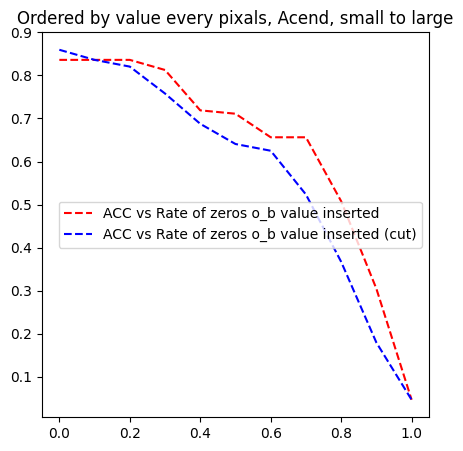

In [189]:
# what if we add 0 ordered by the value?
from tqdm import tqdm
# get the number of zeros and positions
out_cpu = out.cpu().numpy()
# reverse the order
nz_c = np.sum(out_cpu != 0, axis=(0, 1))

nz_pos = [[[] for x in range(16)] for y in range(16)]
for i in range (16):
    for j in range(16):
        for k in range(128):
            for l in range(32):
                if out_cpu[k,l,i,j] != 0:
                    nz_pos[i][j].append((out_cpu[k,l,i,j], k,l,i,j))
        nz_pos[i][j] = sorted(nz_pos[i][j], key=lambda x: x[0])
# following the upper block
more_zeros = [x/10 for x in range (11)]
# reverse the order
accuracy = []
for n_z in tqdm(more_zeros):
    emb = np.copy(out_cpu)
    # print('old emb ',np.sum(emb[:,:,0,0] != 0))
    for ind, zp0 in enumerate(nz_pos): # 16
        for ind2, zp1 in enumerate(zp0): # for every pixal
            n_zero = n_z*nz_c[ind, ind2] # no of numbers needed to insert to the e_temp
            # sample the zero positions
            # r_zero = np.random.choice(nz_c[ind], int(n_zero))
            # print(len(nz_pos[ind][ind2][:int(n_zero)]))
            for r_z in nz_pos[ind][ind2][:int(n_zero)]:
                # print(r_z[1:][0])
                emb[r_z[1:]] = 0
                # print(np.nonzero(emb))
            # print(count)
    # print('n_zero = n_z*nz_c[ind, ind2] ', (n_z*nz_c[0, 0]))
    # print('new emb ',np.sum(emb[:,:,0,0] != 0))
    emb = torch.tensor(emb).cuda()
    pred = server(emb).detach()
    pred = torch.argmax(pred, dim=1)
    pred_acc = torch.sum(pred == label).item()/128
    accuracy.append(pred_acc)

plt.figure(figsize=(5,5))
plt.plot(more_zeros, accuracy, 'r--', label='ACC vs Rate of zeros o_b value inserted')

out_cut_cpu = out_cut.cpu().numpy()
nz_c = np.sum(out_cpu != 0, axis=(0, 1))

nz_pos = [[[] for x in range(16)] for y in range(16)]
for i in range (16):
    for j in range(16):
        for k in range(128):
            for l in range(32):
                if out_cut_cpu[k,l,i,j] != 0:
                    nz_pos[i][j].append((out_cut_cpu[k,l,i,j], k,l,i,j))
        nz_pos[i][j] = sorted(nz_pos[i][j], key=lambda x: x[0])
# following the upper block
more_zeros = [x/10 for x in range (11)]
# reverse the order
accuracy = []
for n_z in tqdm(more_zeros):
    emb = np.copy(out_cut_cpu)
    for ind, zp0 in enumerate(nz_pos): # 16
        for ind2, zp1 in enumerate(zp0):
            e_temp = emb[:, :, ind, ind2]
            n_zero = n_z*nz_c[ind, ind2] # no of numbers needed to insert to the e_temp
            # sample the zero positions
            # r_zero = np.random.choice(nz_c[ind], int(n_zero))
            for r_z in nz_pos[ind][ind2][:int(n_zero)]:
                emb[r_z[1:]] = 0
            emb[:, :, ind, ind2] = e_temp
    emb = torch.tensor(emb).cuda()
    pred = server(emb).detach()
    pred = torch.argmax(pred, dim=1)
    pred_acc = torch.sum(pred == label).item()/128
    accuracy.append(pred_acc)

plt.plot(more_zeros, accuracy, 'b--', label='ACC vs Rate of zeros o_b value inserted (cut)')
plt.legend()
plt.title('Ordered by value every pixals, Acend, small to large')
plt.show()
